In [1]:
import pandas as pd
import numpy as np
import functools
from tensorflow import keras
from tensorflow.keras import utils
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import gc
import pickle

In [2]:
data = pd.read_excel(r'/home/sudarsun/projects/mldl/Sudar_sir_claims_scrubber_data_historical_v1.xlsx')

In [3]:
data.columns

Index(['claim_id', 'patient_id', 'payer_id', 'plan_name', 'denial_code',
       'code_activity', 'activity_desc', 'type_activity', 'act_type_dsc',
       'pdx', 'sdx', 'Reason_for_visit', 'consolidated_diagnoses'],
      dtype='object')

In [4]:
nrecords = len(data)

In [41]:
# we are strongly assuming that the data is not multi-label.
# get the unique cpt codes
cpt = pd.unique(list(data["code_activity"]))
print("unique CPT codes ->", cpt)
print("# unique CPTs: ", len(cpt))

unique CPT codes -> [76700 99283 'I88-4273-03444-01' ... 82384 'C15-1794-00146-01' 73706]
# unique CPTs:  1574


In [42]:
#clear previously owned
if "pdx_icds" in locals():
    # release the memory blocks
    del(pdx_icds)
    del(sdx_icds)
    del(rov_icds)
    gc.collect()
    
# collect the icd codes from the diagnosis columns
pdx_icds = [str(code).split(',') for code in data[data["pdx"].notna()]["pdx"]]
sdx_icds = [str(code).split(',') for code in data[data["sdx"].notna()]["sdx"]] 
rov_icds = [str(code).split(',') for code in data[data["Reason_for_visit"].notna()]["Reason_for_visit"]]

In [43]:
# collect the pdx items
pdx = []
for row in pdx_icds:
    for code in row:
        pdx.append(code)
# collect the sdx items
sdx = []
for row in sdx_icds:
    for code in row:
        sdx.append(code)
# collect the rov items        
rov = []
for row in rov_icds:
    for code in row:
        rov.append(code)

In [44]:
denial_codes = pd.unique(data["denial_code"])
print("labels found", denial_codes)

labels found [nan 'MNEC-004' 'PRCE-010' 'PRCE-002' 'CLAI-012' 'MNEC-005' 'CODE-010'
 'DUPL-002' 'PRCE-001' 'PRCE-006' 'CODE-014' 'AUTH-001' 'AUTH-003'
 'CLAI-016' 'PRCE-007' 'NCOV-003' 'NCOV-001' 'AUTH-005' 'ELIG-005'
 'ELIG-001' 'ELIG-007' 'ELIG-006' 'CLAI-008' 'MNEC-003' 'AUTH-004'
 'NCOV-0026' 'TIME-001' 'BENX-002' 'COPY-001' 'BENX-005' 'CLAI-018'
 'DUPL-001']


In [45]:
data["denial_code"].value_counts()

MNEC-004     102590
PRCE-002       7419
PRCE-001       7305
CODE-010       4061
MNEC-005       3894
CLAI-012       1827
NCOV-0026      1518
DUPL-002       1413
PRCE-006        609
COPY-001        400
NCOV-001        337
AUTH-001        308
PRCE-010        286
CODE-014        245
ELIG-006        216
NCOV-003        213
ELIG-001        210
PRCE-007        186
TIME-001        178
CLAI-008        117
ELIG-007        116
AUTH-003        105
CLAI-016         62
BENX-002         59
BENX-005         57
AUTH-005         50
ELIG-005         43
MNEC-003         42
AUTH-004         29
DUPL-001          2
CLAI-018          1
Name: denial_code, dtype: int64

In [46]:
# get the unique ICD codes.
icd = pd.unique(pdx + sdx + rov)
print("unique icd codes ->", icd)
print("# unique icds: ", len(icd))

unique icd codes -> ['R10.84' 'K76.0' 'M25.562' ... 'S80.811D' 'K25.3' 'T24.012A']
# unique icds:  7388


In [47]:
# forward and reverse index the unique codes.
icd_indices = dict((i,c) for c,i in enumerate(icd))
cpt_indices = dict((str(c),i) for i, c in enumerate(cpt))
denial_indices = dict((str(c),i) for i, c in enumerate(denial_codes))

In [48]:
denial_indices

{'nan': 0,
 'MNEC-004': 1,
 'PRCE-010': 2,
 'PRCE-002': 3,
 'CLAI-012': 4,
 'MNEC-005': 5,
 'CODE-010': 6,
 'DUPL-002': 7,
 'PRCE-001': 8,
 'PRCE-006': 9,
 'CODE-014': 10,
 'AUTH-001': 11,
 'AUTH-003': 12,
 'CLAI-016': 13,
 'PRCE-007': 14,
 'NCOV-003': 15,
 'NCOV-001': 16,
 'AUTH-005': 17,
 'ELIG-005': 18,
 'ELIG-001': 19,
 'ELIG-007': 20,
 'ELIG-006': 21,
 'CLAI-008': 22,
 'MNEC-003': 23,
 'AUTH-004': 24,
 'NCOV-0026': 25,
 'TIME-001': 26,
 'BENX-002': 27,
 'COPY-001': 28,
 'BENX-005': 29,
 'CLAI-018': 30,
 'DUPL-001': 31}

In [49]:
def encode_column(coldata, index):
    encoded = []
    for r in coldata:
        # check for nan by doing this comparison.
        if r != r:
            encoded.append([])
        else:
            codes = list(map(lambda x: index[x], str(r).split(",")))
            encoded.append(codes)
    return encoded

In [52]:
# encode the claim result
claim_status = data["denial_code"].notna()
#let's first compute the class prior
prior = claim_status.value_counts(normalize=True)
print(prior)

data["denial_code"].value_counts()

False    0.781381
True     0.218619
Name: denial_code, dtype: float64


MNEC-004     102590
PRCE-002       7419
PRCE-001       7305
CODE-010       4061
MNEC-005       3894
CLAI-012       1827
NCOV-0026      1518
DUPL-002       1413
PRCE-006        609
COPY-001        400
NCOV-001        337
AUTH-001        308
PRCE-010        286
CODE-014        245
ELIG-006        216
NCOV-003        213
ELIG-001        210
PRCE-007        186
TIME-001        178
CLAI-008        117
ELIG-007        116
AUTH-003        105
CLAI-016         62
BENX-002         59
BENX-005         57
AUTH-005         50
ELIG-005         43
MNEC-003         42
AUTH-004         29
DUPL-001          2
CLAI-018          1
Name: denial_code, dtype: int64

In [51]:
# let's split the train and test datasets from the input.
proportion = 0.8
train_size = int(nrecords * 0.8)

# generate a random permutation of the indicces
p_index = np.random.permutation(nrecords)

# identify the items for training and hold out.
tr_index = dict((k,i) for (i,k) in enumerate(p_index[0:train_size]))
te_index = dict((k,i) for (i,k) in enumerate(p_index[train_size:]))


In [14]:
# set the required testing data prior
#test_prior = {False:0.5, True:0.5}
test_prior = prior

# override the train prior if needed
train_prior = prior
#train_prior = {False:0.5, True:0.5}

In [40]:
train_prior

False    0.781381
True     0.218619
Name: denial_code, dtype: float64

In [16]:
# set the number of required training & testing sample sizes
ntrain = 160000
ntest = 40000

In [17]:
# now collect the ids for training and testing samples.
train_ids = []    
test_ids = []

cum_train = 0
cum_test = 0
# now, we have to draw the sample from tr_indexed data points, hopefully following the class prior.
for c in prior.keys():
    # get the required training data count
    req_ntrain = int(train_prior[c] * ntrain)
    req_ntest = int(test_prior[c] * ntest)
    # get the keys from the data
    keys = data[data["denial_code"].notna()==c]["denial_code"].keys()
    print("required", req_ntrain, "train points from class", c)
    print("required", req_ntest, "test points from class", c)
    print("available", len(keys), "points from class", c)
    for k in keys:
        if k in tr_index and len(train_ids)-cum_train < req_ntrain:
            train_ids.append(k)
        if k in te_index and len(test_ids)-cum_test < req_ntest:
            test_ids.append(k)
    print("got", len(train_ids)-cum_train, "train points from class", c)
    print("got", len(test_ids)-cum_test, "test points from class", c)
    cum_train = len(train_ids)
    cum_test = len(test_ids)

required 125020 train points from class False
required 31255 test points from class False
available 478574 points from class False
got 125020 train points from class False
got 31255 test points from class False
required 34979 train points from class True
required 8744 test points from class True
available 133898 points from class True
got 34979 train points from class True
got 8744 test points from class True


In [18]:
#encode the PDX column
pdx_encoded_tr = encode_column(data["pdx"][train_ids], icd_indices)
pdx_encoded_te = encode_column(data["pdx"][test_ids], icd_indices)

In [19]:
#encode the SDX column
sdx_encoded_tr = encode_column(data["sdx"][train_ids], icd_indices)
sdx_encoded_te = encode_column(data["sdx"][test_ids], icd_indices)

In [20]:
# encode the ROV column
rov_encoded_tr = encode_column(data["Reason_for_visit"][train_ids], icd_indices)
rov_encoded_te = encode_column(data["Reason_for_visit"][test_ids], icd_indices)

In [21]:
# encode the CPT column
cpt_encoded_tr = encode_column(data["code_activity"][train_ids], cpt_indices)
cpt_encoded_te = encode_column(data["code_activity"][test_ids], cpt_indices)

In [23]:
def transform_denial_code(c, denial_index):
    if c != c:
        return 0
    return denial_index[c]

In [24]:
# encode the denial column
denial_encoded_tr = list(map(lambda x: transform_denial_code(x, denial_indices), data["denial_code"][train_ids]))
denial_encoded_te = list(map(lambda x: transform_denial_code(x, denial_indices), data["denial_code"][test_ids]))

In [39]:
pd.DataFrame(denial_encoded_tr).value_counts()

0     125020
1      29304
3       1980
5       1167
6       1038
4        417
7        320
9        131
8        121
2         97
11        95
14        70
10        58
16        55
21        44
12        17
18        13
20        11
22        11
13        10
15         9
19         5
17         2
23         2
24         1
25         1
dtype: int64

In [25]:
# get the output column ready
y_train = list(claim_status[train_ids])
y_test = list(claim_status[test_ids])

In [26]:
def one_hot(record, num_classes):
    encoded = np.zeros(num_classes)
    for r in record:
        encoded[r] = 1.
    return encoded

In [27]:
def one_hot_encode(index, multilabel):
    encoded = np.zeros(len(index))
    for label in multilabel:
        print(label)
        if label in index:
            print(index[label])
            encoded[index[label]] = 1.
    return encoded

In [28]:
claim_status[test_ids]

2         False
13        False
32        False
34        False
38        False
          ...  
217789     True
217797     True
217806     True
217886     True
217908     True
Name: denial_code, Length: 39999, dtype: bool

In [29]:
# free up the space explicitly
if 'X_train' in locals():
    del(X_train) 
    del(X_test)
    gc.collect()

X_train = [np.hstack((one_hot(cpt_encoded_tr[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_tr[i], num_classes=len(icd_indices)))) for i in range(len(train_ids))]
X_test  = [np.hstack((one_hot(cpt_encoded_te[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_te[i], num_classes=len(icd_indices)))) for i in range(len(test_ids))]

In [30]:
# free up the space explicitly
if 'features' in locals():
    del(features)
    gc.collect()

features = list(cpt_indices.keys()) + ["ROV-"+k for k in icd_indices.keys()] + ["SDX-"+k for k in icd_indices.keys()] + ["PDX-"+k for k in icd_indices.keys()]
print(len(features))

23738


In [31]:
dt = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)
#dt.fit(X_train, y_train)
dt.fit(X_train, denial_encoded_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)

In [32]:
y_pred = dt.predict(X_test)

In [33]:
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(denial_encoded_te, y_pred)

print(cm)
accuracy = (cm[0,0] + cm[1,1])/sum(sum(cm))
print("accuracy = ", accuracy)
precision_A = cm[0,0]/(cm[0,0]+cm[1,0])
recall_A = cm[0,0]/(cm[0,0]+cm[0,1])
precision_B = cm[1,1]/(cm[1,1]+cm[0,1])
recall_B = cm[1,1]/(cm[1,1]+cm[1,0])
print("class A: Precision = ", precision_A, " Recall = ", recall_A)
print("class B: Precision = ", precision_B, " Recall = ", recall_B)

[[30954   219     0    76     0     0     6     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [ 6163  1150     0    25     0     0     1     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [   25     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [  104     0     0   398     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [  102     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [  252     5     0     2     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [   96    82     0     0     0     0    87     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]

In [67]:
list(map(lambda x: transform_denial_code(x, denial_indices), data["denial_code"][train_ids]))

[1, 5, 1, 5, 1, 1, 1, 1, 1]

In [58]:
encode_column(data["denial_code"][3:20], denial_indices)

[[1], [], [], [1], [], [], [1], [1], [1], [1], [], [1], [1], [1], [1], [], [1]]

[Text(1890.0, 1993.2, '82607 <= 0.5\ngini = 0.342\nsamples = 159999\nvalue = [125020, 34979]'),
 Text(1269.0, 1630.8000000000002, '84550 <= 0.5\ngini = 0.328\nsamples = 156574\nvalue = [124205, 32369]'),
 Text(810.0, 1268.4, '83735 <= 0.5\ngini = 0.319\nsamples = 154664\nvalue = [123913, 30751]'),
 Text(432.0, 906.0, '84630 <= 0.5\ngini = 0.311\nsamples = 153114\nvalue = [123660, 29454]'),
 Text(216.0, 543.5999999999999, '85652 <= 0.5\ngini = 0.306\nsamples = 152281\nvalue = [123576, 28705]'),
 Text(108.0, 181.19999999999982, 'gini = 0.3\nsamples = 150914\nvalue = [123205, 27709]'),
 Text(324.0, 181.19999999999982, 'gini = 0.395\nsamples = 1367\nvalue = [371, 996]'),
 Text(648.0, 543.5999999999999, 'SDX-E60 <= 0.5\ngini = 0.181\nsamples = 833\nvalue = [84, 749]'),
 Text(540.0, 181.19999999999982, 'gini = 0.018\nsamples = 754\nvalue = [7, 747]'),
 Text(756.0, 181.19999999999982, 'gini = 0.049\nsamples = 79\nvalue = [77, 2]'),
 Text(1188.0, 906.0, 'SDX-E61.2 <= 0.5\ngini = 0.273\nsamples

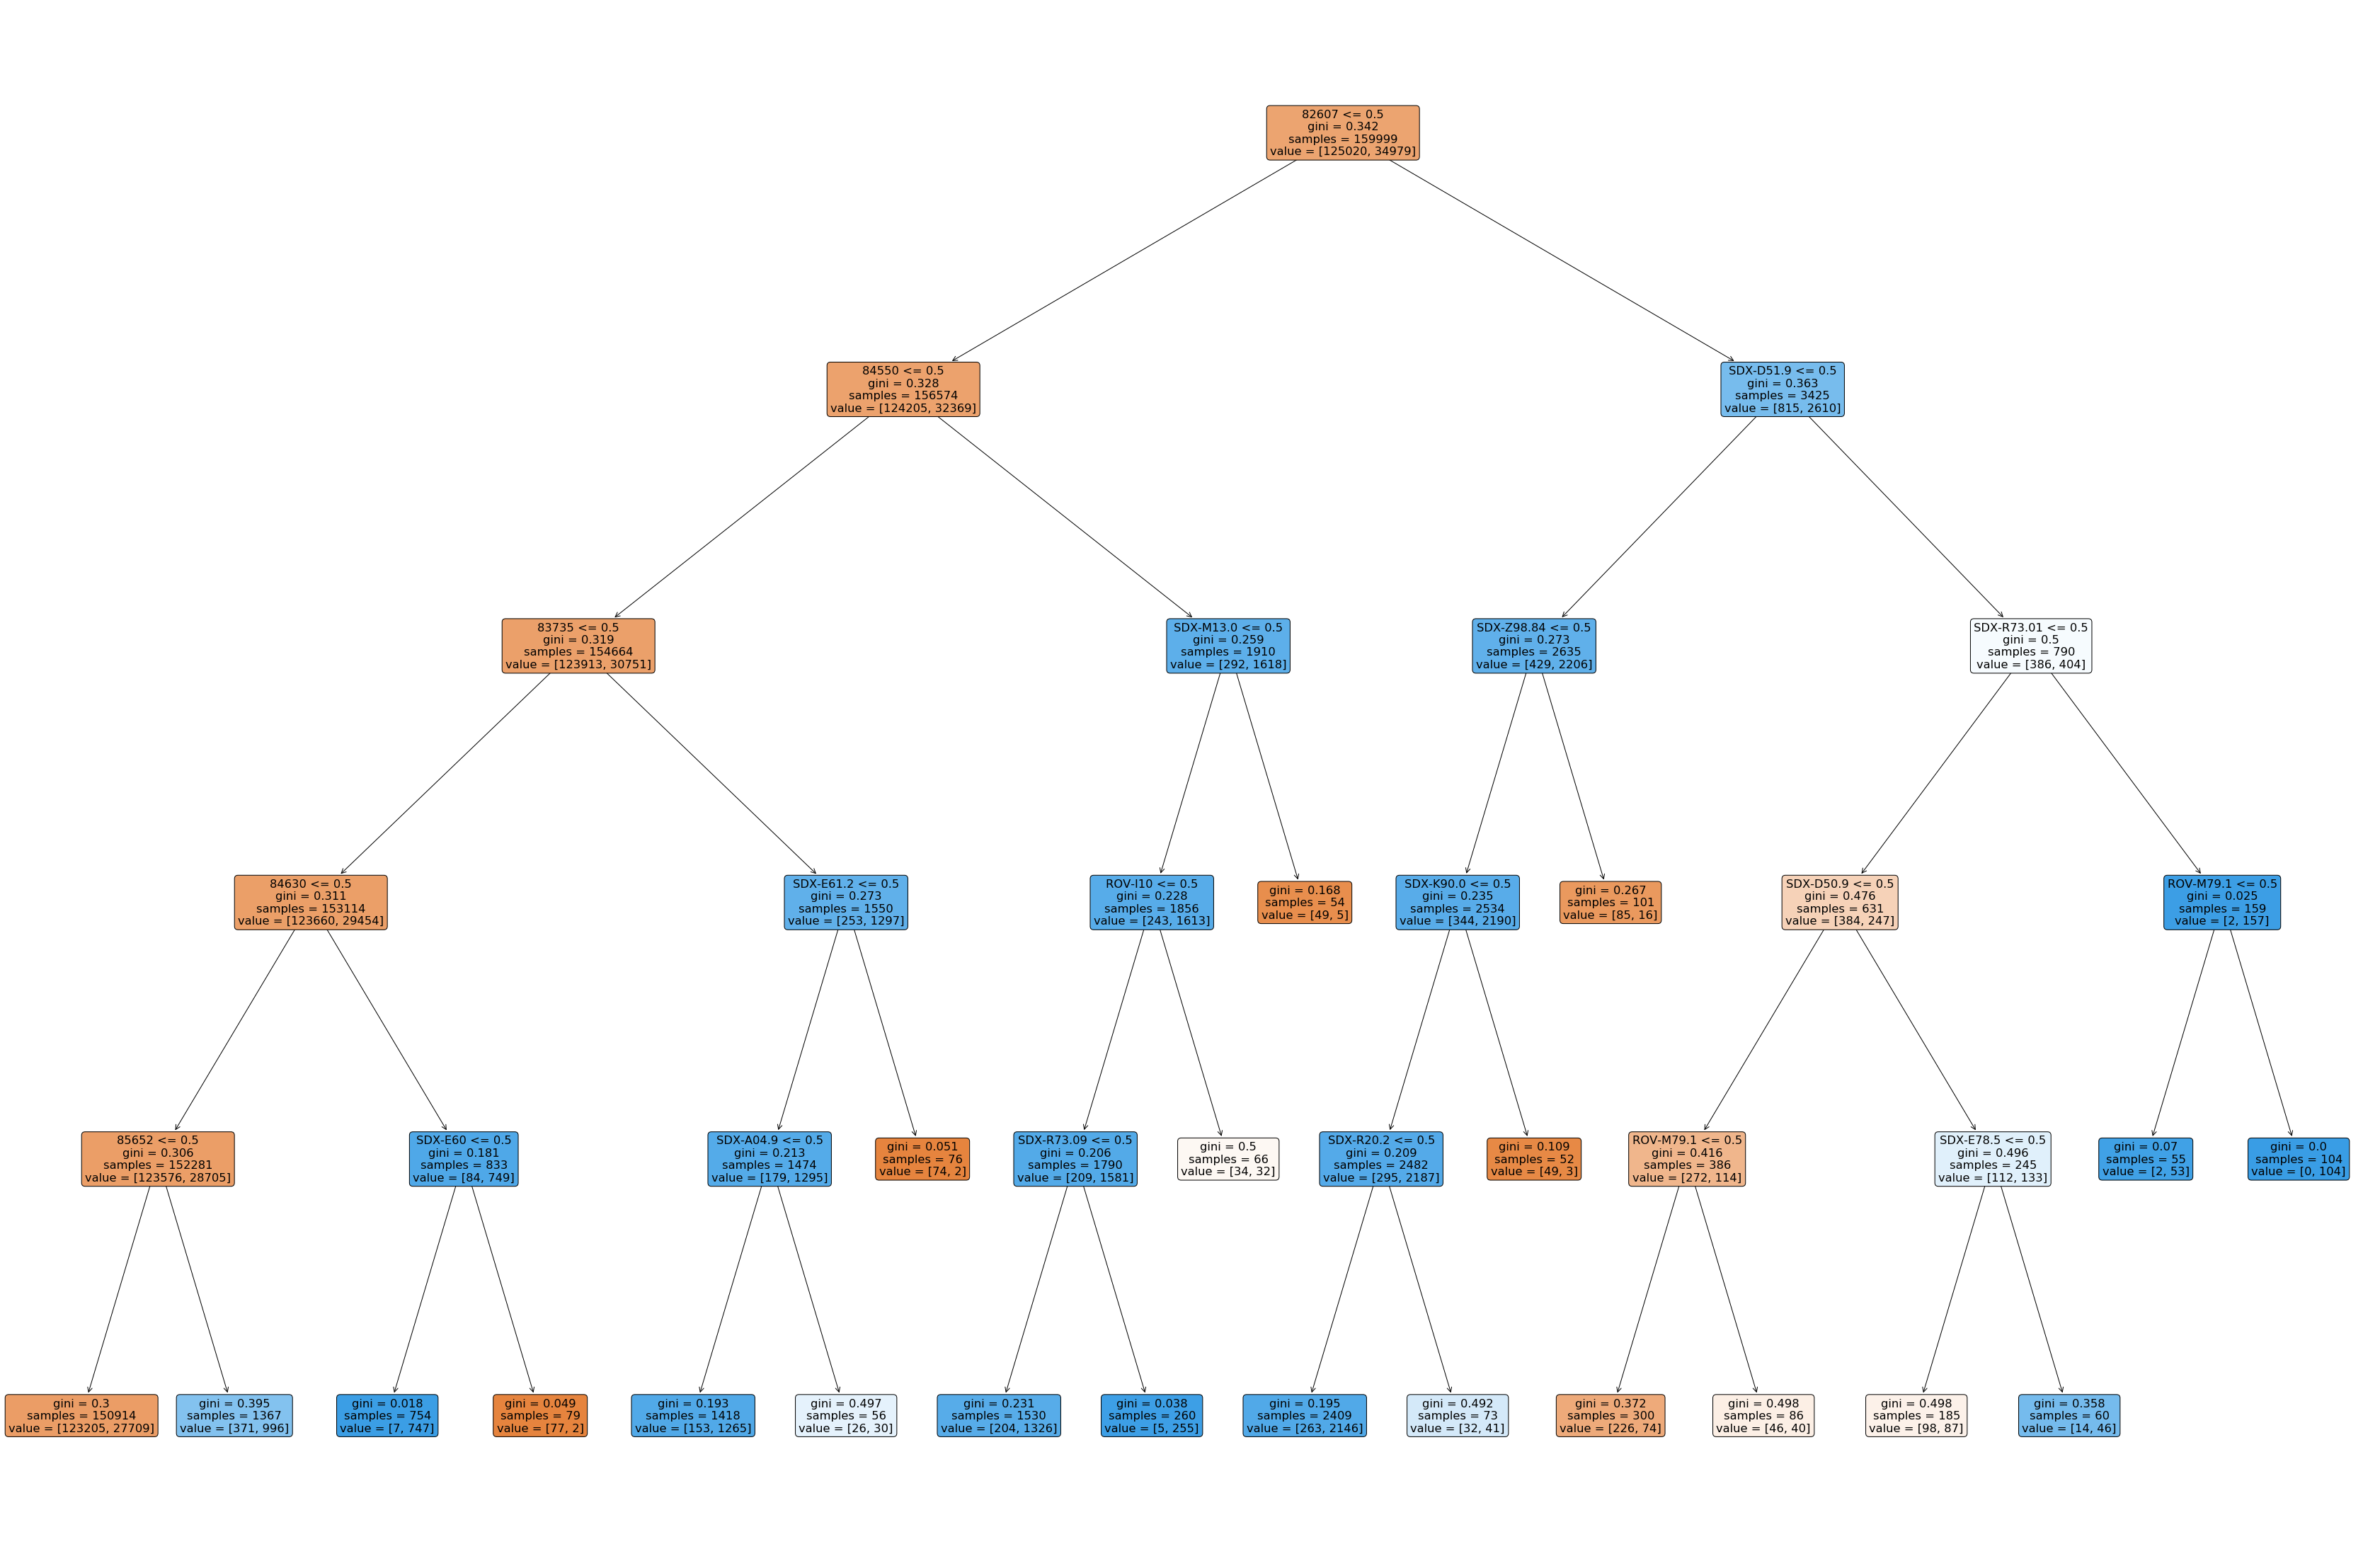

In [36]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(60,40))
plot_tree(dt, filled=True, rounded=True, impurity=True, feature_names=features)

In [37]:
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [38]:
rules = get_rules(dt, features, list(["True", "False"]))
for r in rules:
    print(r)

if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (84630 <= 0.5) and (85652 <= 0.5) then class: True (proba: 81.64%) | based on 150,914 samples
if (82607 > 0.5) and (SDX-D51.9 <= 0.5) and (SDX-Z98.84 <= 0.5) and (SDX-K90.0 <= 0.5) and (SDX-R20.2 <= 0.5) then class: False (proba: 89.08%) | based on 2,409 samples
if (82607 <= 0.5) and (84550 > 0.5) and (SDX-M13.0 <= 0.5) and (ROV-I10 <= 0.5) and (SDX-R73.09 <= 0.5) then class: False (proba: 86.67%) | based on 1,530 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 > 0.5) and (SDX-E61.2 <= 0.5) and (SDX-A04.9 <= 0.5) then class: False (proba: 89.21%) | based on 1,418 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (84630 <= 0.5) and (85652 > 0.5) then class: False (proba: 72.86%) | based on 1,367 samples
if (82607 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (84630 > 0.5) and (SDX-E60 <= 0.5) then class: False (proba: 99.07%) | based on 754 samples
if (82607 > 0.5) and (SDX-D51.9 > 0.5) and (SDX-R7